## 爬取网址

In [ ]:
import requests
from lxml import etree
import os
import csv

# 获取当前工作目录（适用于 Jupyter、交互式终端）
script_dir = os.getcwd()

# 输出CSV路径
csv_path = os.path.join(script_dir, 'ubpa_all_pages.csv')

# 创建CSV文件并写入表头
with open(csv_path, 'w', encoding='utf-8', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['标题', '日期', '链接', '简介'])  # 写入表头

    # 循环爬取 1~35 页
    for page_num in range(1, 36):
        url = f'http://www.ubpa.com.cn/index.php?c=content&a=list&catid=7&page={page_num}'
        print(f'正在爬取第 {page_num} 页：{url}')
        try:
            response = requests.get(url, timeout=10)
            response.encoding = 'utf-8'  # 避免编码乱码
            html = response.text
        except Exception as e:
            print(f'⚠️ 第 {page_num} 页请求失败：{e}')
            continue

        root = etree.HTML(html)
        news_items = root.xpath('//div[@class="news-c"]/ul/li')
        print(f'  提取到 {len(news_items)} 条新闻')

        for item in news_items:
            title = item.xpath('.//p[@class="news-c1"]/a/text()')
            title = title[0].strip() if title else ''
            link = item.xpath('.//p[@class="news-c1"]/a/@href')
            link = 'http://www.ubpa.com.cn' + link[0] if link else ''
            date = item.xpath('.//p[@class="news-c1"]/em/text()')
            date = date[0].strip() if date else ''
            summary = item.xpath('.//p[@class="news-c2"]/text()')
            summary = summary[0].strip() if summary else ''

            writer.writerow([title, date, link, summary])


## 提取到txt文件

In [17]:
import csv
import os

# 使用当前工作目录（兼容Jupyter和交互式环境）
script_dir = os.getcwd()

# 输入CSV路径
csv_path = os.path.join(script_dir, 'ubpa_all_pages.csv')

# 输出TXT路径
txt_path = os.path.join(script_dir, 'ubpa_summary.txt')

# 读取CSV并写入TXT，同时去除简介中的所有 '</h1>' 标签
with open(csv_path, 'r', encoding='utf-8') as csv_file, \
     open(txt_path, 'w', encoding='utf-8') as txt_file:

    reader = csv.DictReader(csv_file)

    for row in reader:
        summary = row['简介'].strip()
        # 去除所有 '</h1>' 标签
        summary_clean = summary.replace('</h1>', '')
        txt_file.write(f'{summary_clean}\n')

print('✅ 简介内容已成功写入 ubpa_summary.txt，且已去除所有 </h1> 标签。')


✅ 简介内容已成功写入 ubpa_summary.txt，且已去除所有 </h1> 标签。


## 生成词云

词频最高的20个词:
世博: 184
建筑: 91
新: 68
世界: 65
UBPA: 65
创意: 60
上海市: 59
秀场: 58
绿色: 58
生活: 57
文化: 56
中国: 56
世博会: 54
发展: 53
滨江: 50
黄浦: 48
设计: 48
人: 44
半淞园: 43
公司: 43
✅ 词云已保存到: /Users/elsa/Desktop/爬虫学习/wordcloud.png


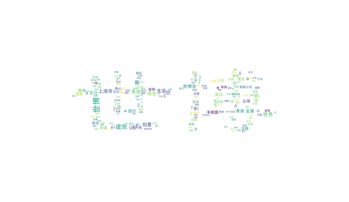

In [41]:
import os
import jieba
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image
import numpy as np
import re

# 停用词文件路径
stopwords_path = '/Users/elsa/Desktop/爬虫学习/园区停用词表.txt'

script_dir = os.getcwd()
txt_path = os.path.join(script_dir, 'ubpa_summary.txt')
wordcloud_path = os.path.join(script_dir, 'wordcloud.png')

# 读取停用词
with open(stopwords_path, 'r', encoding='utf-8') as f:
    stopwords = set(line.strip() for line in f if line.strip())

# 自定义词
jieba.add_word('城市最佳实践区', freq=20000)


# 读取文本
with open(txt_path, 'r', encoding='utf-8') as f:
    text = f.read()

text = re.sub(r'\d+', '', text)

# 分词并过滤停用词
words = jieba.cut(text)
filtered_words = [w for w in words if w.strip() and w not in stopwords]

# 归一化词语，把“实践区”和“世博”都替换成“城市最佳实践区”
normalized_words = [
    '城市最佳实践区' if w in ['实践区', '世博'] else w
    for w in filtered_words
]

# 词频统计
word_counts = Counter(filtered_words)

mask_img = np.array(Image.open('/Users/elsa/Desktop/爬虫学习/mask.png'))

# 打印词频最高的20个词
print('词频最高的20个词:')
for word, freq in word_counts.most_common(20):
    print(f'{word}: {freq}')

# 生成词云，直接用词频字典
wc = WordCloud(
    font_path='/System/Library/Fonts/STHeiti Medium.ttc',
    background_color='white',
    width=800,
    height=600,
    max_words=200,
    mask = mask_img
)

wc.generate_from_frequencies(word_counts)
wc.to_file(wordcloud_path)
print(f'✅ 词云已保存到: {wordcloud_path}')

plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()
